In [25]:
import pandas as pd
import numpy as np
from langchain_community.embeddings.ollama import OllamaEmbeddings

Embed all lines.

In [4]:
df = pd.read_csv('./data/new_data.csv')
df = df[~df['R2DiscussionType'].str.contains(",")]

In [5]:
df['R2DiscussionType'].value_counts()

R2DiscussionType
Seminar              333
Deliberation          85
Social                69
UX                    47
Procedure             46
Imaginative entry     18
Other                  6
Imaginative            2
Name: count, dtype: int64

In [6]:
df['R2DiscussionType'] = df['R2DiscussionType'].map(lambda x: 'Imaginative entry' if x == 'Imaginative' else x)

In [7]:
df['R2DiscussionType'].value_counts()

R2DiscussionType
Seminar              333
Deliberation          85
Social                69
UX                    47
Procedure             46
Imaginative entry     20
Other                  6
Name: count, dtype: int64

In [8]:
with open('./unprocessed_data/definitions.json', 'r') as file:
    instructions = file.read()

In [9]:
len(instructions)

5142

In [10]:
ollama_emb = OllamaEmbeddings(
    model="llama3",
    # embed_instruction=instructions
)

In [11]:
embeddings = ollama_emb.embed_documents(list(df['Message']))

In [12]:
embeddings = np.array(embeddings)

Get labels

In [14]:
labels = df['R2DiscussionType'].map(lambda x: next((i for i, v in enumerate(np.unique(df['R2DiscussionType'])) if v == x), None))

Reduce dimensionality

In [8]:
import umap

In [15]:
reducer = umap.UMAP()

In [19]:
reduced = reducer.fit_transform(embeddings)
reduced.shape

(606, 2)

Plot UMAP

In [17]:
from matplotlib import pyplot as plt

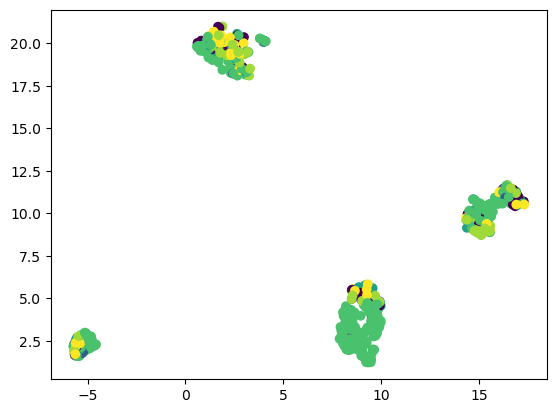

In [20]:
plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=labels
)
plt.show()

In [21]:
from sklearn.cluster import KMeans

Looking at what groups we get

In [38]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(reduced)

KMeans()

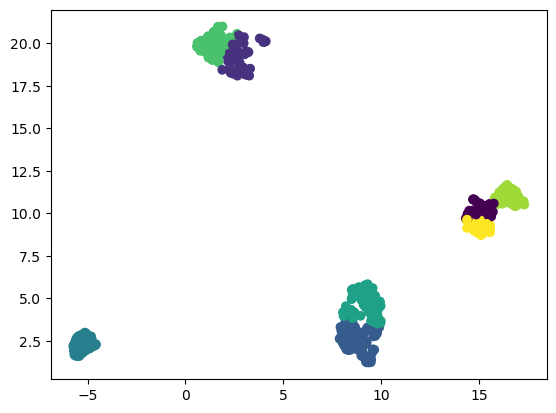

In [39]:
plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans.labels_)
plt.show()

In [43]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 240)
df[kmeans.labels_ == 1][['Message', 'R2DiscussionType']]

,Message,R2DiscussionType
1,My assumption is,Seminar
11,"It doesn't appear so. For instance, she discloses great agony, jealousy, and stress about the potential wedding between her lover and the lady behind the door;",Seminar
13,mor,Other
14,"more upset with the prospect of him belonging to another, and so it is clear,",Seminar
15,"given the two terrible choices,",Seminar
19,"I would imagine,",Seminar
21,"However, I also do not",Seminar
22,ima,Seminar
31,I also agree with Ashley,Seminar
36,opportun,Seminar


Let's try classifying width the high dimensional vectors.

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

In [56]:
clf = RidgeClassifier()
scores = cross_val_score(clf, embeddings, labels, cv=5)
scores

/nix/store/bbilhkh35cdldw231babbkycawvy38wq-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


array([0.6147541 , 0.6446281 , 0.6446281 , 0.68595041, 0.74380165])

This doesn't look like it's leading anywhere. I think the llama embeddings are too complex. Althouuuuugh I can try
LDA maybe that will be good.

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

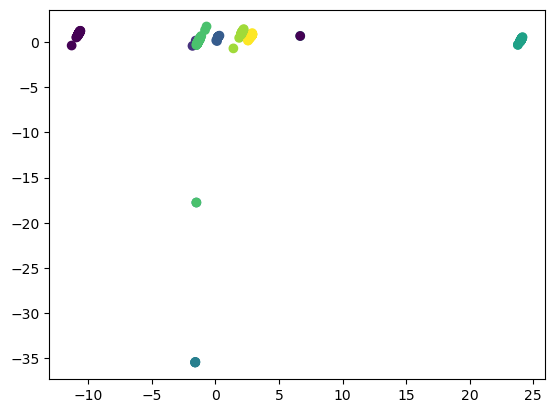

In [59]:
clf = LinearDiscriminantAnalysis(n_components=2)
ldad = clf.fit_transform(embeddings, labels)
plt.scatter(
    ldad[:, 0],
    ldad[:, 1],
    c=labels
)
plt.show()

In [70]:
df.iloc[np.squeeze(np.argwhere(ldad[:, 1] < -15))]['Message']
# stupid gibberish data

13        mor
59          s
72     uwgyeu
77        ha"
85          w
176     darla
436         w
Name: Message, dtype: object

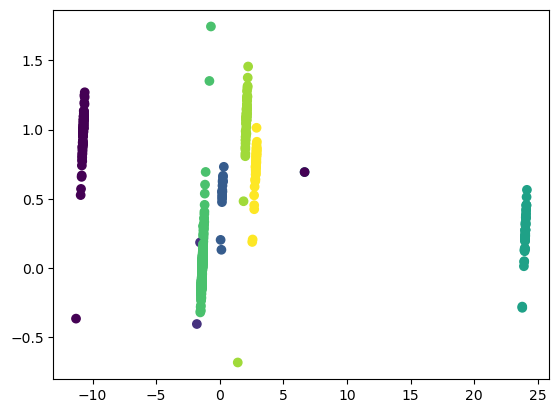

In [76]:
plt.scatter(
    ldad[ldad[:, 1] >= -15][:, 0],
    ldad[ldad[:, 1] >= -15][:, 1],
    c=np.array(labels)[ldad[:, 1] >= -15]
)
plt.show()
# This looks oddly good. Should try cross evaluation

In [81]:
# Scores very bad. weird
scores = cross_val_score(LinearDiscriminantAnalysis(n_components=2), embeddings, labels, cv=3)
scores

/nix/store/bbilhkh35cdldw231babbkycawvy38wq-python3-3.11.9-env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


array([0.52970297, 0.69306931, 0.62871287])

Let's try some cross val since I don't trust this

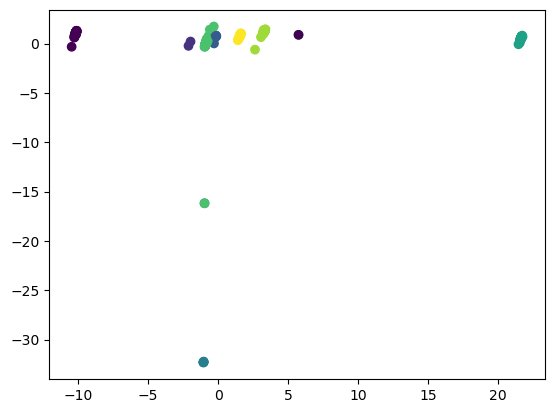

In [78]:
clf = LinearDiscriminantAnalysis(n_components=2)
ldad = clf.fit_transform(embeddings[:-100], labels[:-100])
plt.scatter(
    ldad[:, 0],
    ldad[:, 1],
    c=labels[:-100]
)
plt.show()

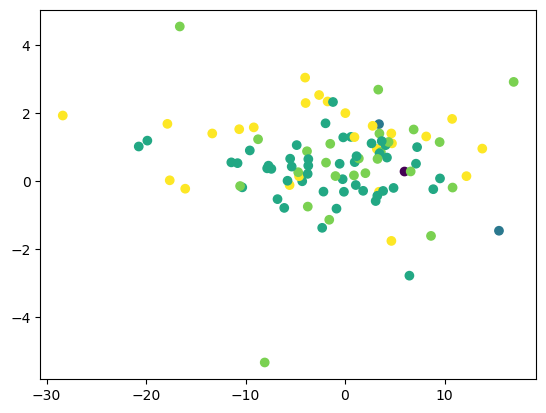

In [83]:
predicted = clf.transform(embeddings[-100:])
plt.scatter(
    predicted[:, 0],
    predicted[:, 1],
    c=labels[-100:]
)
plt.show()
# Okay this is obviously not working. Not good LDA scam.

This isn't working. I think we need better embeddings. (or less complex ones at least)
Or maybe I'l try t-sne with classes.

In [85]:
from sklearn.manifold import TSNE

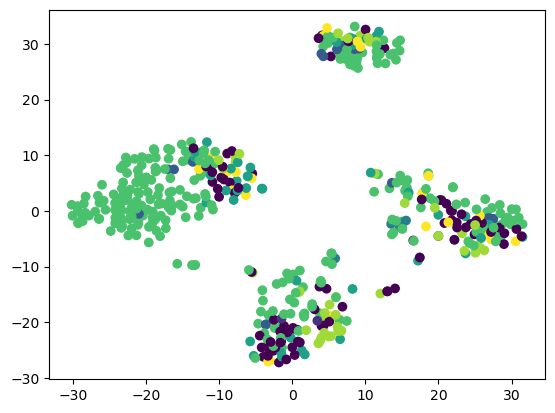

In [88]:
clf = TSNE()
tsned = clf.fit_transform(embeddings[:-100], labels[:-100])
plt.scatter(
    tsned[:, 0],
    tsned[:, 1],
    c=labels[:-100]
)
plt.show()

Well that's not good. How about I try roBERTa.

In [13]:
from transformers import pipeline
classifier = pipeline('zero-shot-classification', model='roberta-large-mnli')

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
entry = 200
print(df['R2DiscussionType'][entry], df['Message'][entry])
classifier(df['Message'][entry], df['R2DiscussionType'].unique())
# doesn't work well, probably because the category names are ambigous.

Seminar Anna Jones, this is what I was thinking. If you really loved him you wouldn’t allow that. Alexandra, I was leaning toward the tiger at first because of the descriptions you gave. The apple doesn’t fall far from the tree and all that. 🙂


{'sequence': 'Anna Jones, this is what I was thinking. If you really loved him you wouldn’t allow that. Alexandra, I was leaning toward the tiger at first because of the descriptions you gave. The apple doesn’t fall far from the tree and all that. 🙂',
 'labels': ['Social',
  'Procedure',
  'Other',
  'Imaginative entry',
  'Deliberation',
  'Seminar',
  'UX'],
 'scores': [0.2618650496006012,
  0.24981561303138733,
  0.17693105340003967,
  0.10347723215818405,
  0.09475091844797134,
  0.06949440389871597,
  0.04366570711135864]}

In [31]:
df['R2DiscussionType'].unique()

array(['Social', 'Seminar', 'Procedure', 'Other', 'Deliberation', 'UX',
       'Imaginative entry'], dtype=object)

In [29]:
# I can try giving the whole description in the category names.
import json
with open('./unprocessed_data/definitions.json') as file:
    definitions = json.loads(file.read())
# definitions[df['R2DiscussionType'].unique()]
definitions = [definitions[x]['Definition'] if x != 'Other' else 'Other' for x in df['R2DiscussionType'].unique()]
definitions

['Discussion that establishes or maintains a relationship and does NOT relate to the assignments.',
 'Discussion on the meaning or interpretation of content. My interpretation vs. your interpretation. What does it mean?',
 'Discussion toward accomplishing a task. How should the task be accomplished? Specifically, discussion of how to complete the assignment.Big Question: How does this work? What does the teacher want us to do with this assignment?',
 'Other',
 'Turns related to decision-making about the content…. Or writing or wording. It also indicates the internal procedure of an individual, and interpersonal functioning of the group. Big Question: What should we do next?',
 "User's opinion about the IMapBook interface, or media they wish we would include, user experience, media, relationship with the media.",
 'Discourse that places the learner in the discussion as an active participant']

In [34]:
entry = 250
print(df['R2DiscussionType'][entry], df['Message'][entry])
classifier(df['Message'][entry], definitions)
# I think roberta is a bit thick.

Deliberation I tried the ones you mentioned it said try again.


{'sequence': 'I tried the ones you mentioned it said try again.',
 'labels': ['Discussion toward accomplishing a task. How should the task be accomplished? Specifically, discussion of how to complete the assignment.Big Question: How does this work? What does the teacher want us to do with this assignment?',
  'Discussion on the meaning or interpretation of content. My interpretation vs. your interpretation. What does it mean?',
  "User's opinion about the IMapBook interface, or media they wish we would include, user experience, media, relationship with the media.",
  'Other',
  'Turns related to decision-making about the content…. Or writing or wording. It also indicates the internal procedure of an individual, and interpersonal functioning of the group. Big Question: What should we do next?',
  'Discussion that establishes or maintains a relationship and does NOT relate to the assignments.',
  'Discourse that places the learner in the discussion as an active participant'],
 'scores': 

Maybe prompting llama3 is all I need.

In [36]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

In [ ]:
response_schemas = [
    ResponseSchema(name="discourse type", description="the type of "),
    ResponseSchema(
        name="source",
        description="source used to answer the user's question, should be a website.",
    ),
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)